---
title: "Spotify Project"
subtitle: "Numeric prediction model"
author: "Oleg Ryzhkov (oryzhkov@chicagobooth.edu)"
date: March 13, 2021
output: neural network model numeric prediction 
---

Load the H2O R package.

- R installation instructions are at http://h2o.ai/download  

In [2]:
library(h2o)

In [3]:
# Start up a 1-node H2O server on your local machine, 
# and allow it to use all CPU cores and up to 8GB of memory.

h2o.init(nthreads=-1, max_mem_size="8G")
h2o.no_progress()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         7 days 12 hours 
    H2O cluster timezone:       America/Chicago 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.0.1 
    H2O cluster version age:    5 months and 4 days !!! 
    H2O cluster name:           H2O_started_from_R_olegryzhkov_tpd759 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.71 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  1 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 4.0.2 (2020-06-22) 


Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (5 months and 4 days)!
Please download and install the latest version from http://h2o.ai/download/”


The `h2o.deeplearning` function fits H2O's 
Deep Learning models from within R.
```{r}
help(h2o.deeplearning)
```

While H2O Deep Learning has many parameters, it is quite easy to use.
Most often we can use the default parameters for many of the inputs.
We should change the following parameters:

- the number and sizes of hidden layers;
- the number of epochs and the activation function;
- add some regularization technique.
  
  
We will apply it to `target_numeric_popularity` data, which
we got cleaning and transforming the original dataset.

In [39]:
# download the file if it does not exist

target.df <- h2o.importFile('https://raw.githubusercontent.com/OlegRyzhkov2020/SpotifyPopularity/main/data/target_numeric_popularity.csv') 
dim(target.df)
head(target.df)

[1] 42371    25

,popularity,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,⋯,language.english,language.catalan,language.german,language.frisian,language.welsh,artist.number,artist.rank_sum,artist.trackcount,artist.trackrankedcount,artist.rank_mean
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,55,0.394,0.484,160187,0.265,0,0.00e+00,0,0.1490,-11.101,⋯,0,0,0,0,0,1,2143,183,182,11.77
2,39,0.255,0.405,141987,0.365,0,4.68e-06,6,0.1630,-10.226,⋯,0,0,0,0,0,1,2143,183,182,11.77
3,34,0.406,0.477,157093,0.352,0,0.00e+00,1,0.1220,-14.165,⋯,1,0,0,0,0,1,2143,183,182,11.77
4,27,0.887,0.319,187333,0.201,0,0.00e+00,7,0.9040,-17.796,⋯,1,0,0,0,0,1,22115,773,773,28.61
5,26,0.938,0.269,236800,0.129,0,4.87e-06,7,0.6830,-18.168,⋯,0,0,0,0,0,1,22115,773,773,28.61
6,30,0.360,0.617,114987,0.711,0,1.59e-06,9,0.0841,-6.433,⋯,0,0,0,0,0,1,2143,183,182,11.77


In [42]:
splits <- h2o.splitFrame(target.df, c(0.6,0.2), seed=1)
train  <- h2o.assign(splits[[1]], "train.hex") # 60%
valid  <- h2o.assign(splits[[2]], "valid.hex") # 20%
test   <- h2o.assign(splits[[3]], "test.hex")  # 20%

We build our first Deep Learning model
where we predict the `popularity` column
using the remaining 24  variables. `h2o` 
will automatically use automatic one-hot encoding.

In [43]:
response <- "popularity"
predictors <- setdiff(names(target.df), response)
predictors

[1] "acousticness"            "danceability"           
 [3] "duration_ms"             "energy"                 
 [5] "explicit"                "instrumentalness"       
 [7] "key"                     "liveness"               
 [9] "loudness"                "mode"                   
[11] "speechiness"             "tempo"                  
[13] "valence"                 "year"                   
[15] "language.english"        "language.catalan"       
[17] "language.german"         "language.frisian"       
[19] "language.welsh"          "artist.number"          
[21] "artist.rank_sum"         "artist.trackcount"      
[23] "artist.trackrankedcount" "artist.rank_mean"

In [44]:
# I only run ten epochs to keep things fast.

m1 <- h2o.deeplearning(
  model_id="dl_model_first", 
  training_frame=train, 
  validation_frame=valid,   ## validation data are used for scoring and early stopping
  x=predictors,
  y=response,
  activation="Rectifier",   ## default
  hidden=c(100,100),       
  epochs=100,
  variable_importances=T    ## not enabled by default
)
summary(m1)

Model Details:

H2ORegressionModel: deeplearning
Model Key:  dl_model_first 
Status of Neuron Layers: predicting popularity, regression, gaussian distribution, Quadratic loss, 12,701 weights/biases, 165.0 KB, 2,576,280 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1    24     Input  0.00 %       NA       NA        NA       NA       NA
2     2   100 Rectifier  0.00 % 0.000000 0.000000  0.007849 0.006239 0.000000
3     3   100 Rectifier  0.00 % 0.000000 0.000000  0.016490 0.039520 0.000000
4     4     1    Linear      NA 0.000000 0.000000  0.001071 0.000759 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2   -0.004540   0.256421  0.238418 0.189426
3   -0.055258   0.187613  0.940057 0.198691
4    0.013799   0.232829  0.003980 0.000000

H2ORegressionMetrics: deeplearning
** Reported on training data. **
** Metrics reported on temporary training frame with 9855 samples 

In [45]:
head(as.data.frame(h2o.varimp(m1)), 10)

,variable,relative_importance,scaled_importance,percentage
,<chr>,<dbl>,<dbl>,<dbl>
1,artist.rank_mean,1.0000000,1.0000000,0.14206161
2,year,0.6106966,0.6106966,0.08675654
3,artist.trackcount,0.5114406,0.5114406,0.07265608
4,duration_ms,0.3883722,0.3883722,0.05517277
5,artist.rank_sum,0.3854611,0.3854611,0.05475922
6,artist.trackrankedcount,0.3667023,0.3667023,0.05209432
7,danceability,0.2650164,0.2650164,0.03764866
8,explicit,0.2635594,0.2635594,0.03744168
9,valence,0.2619976,0.2619976,0.03721980


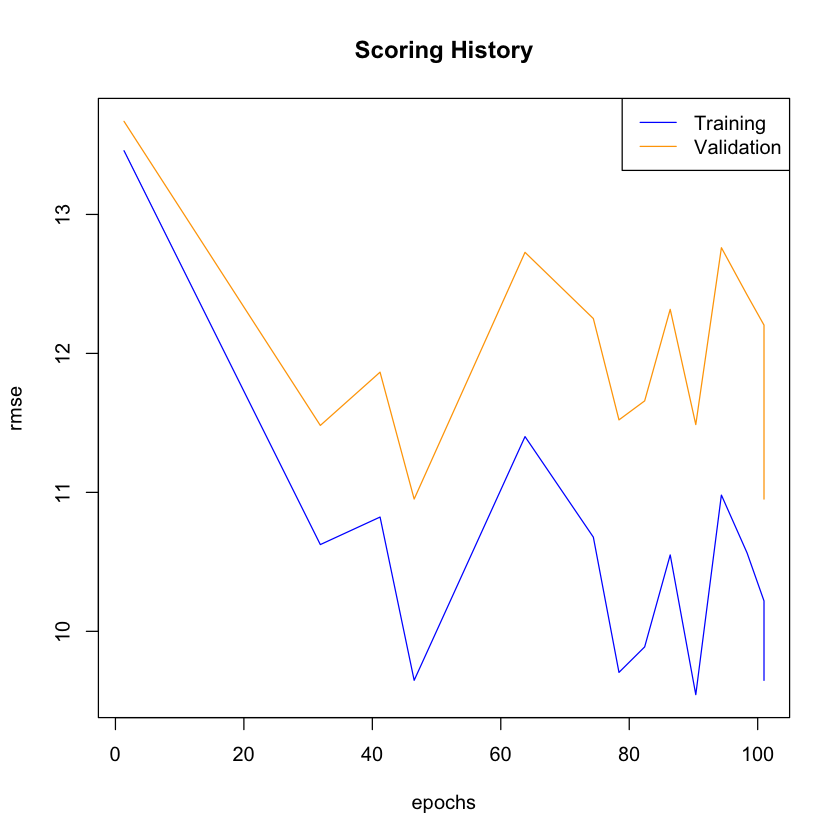

In [46]:
plot(m1)

**Early Stopping**

Here we stop training when the MSE converges 

- the moving average of length 2 does not 
  improve by at least 1% for 2 consecutive scoring events.

Model Details:

H2ORegressionModel: deeplearning
Model Key:  dl_model_faster 
Status of Neuron Layers: predicting popularity, regression, gaussian distribution, Quadratic loss, 1,233 weights/biases, 30.2 KB, 2,100,318 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1    24     Input  0.00 %       NA       NA        NA       NA       NA
2     2    16 Rectifier  0.00 % 0.000000 0.000000  0.003394 0.003274 0.000000
3     3    16 Rectifier  0.00 % 0.000000 0.000000  0.001973 0.001648 0.000000
4     4    16 Rectifier  0.00 % 0.000000 0.000000  0.001916 0.001620 0.000000
5     5    16 Rectifier  0.00 % 0.000000 0.000000  0.002670 0.002815 0.000000
6     6     1    Linear      NA 0.000000 0.000000  0.001199 0.000519 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2   -0.008901   0.299319  0.554953 0.223782
3   -0.018251   0.289924  0.966199 0.137929
4   -0.048454   0.271280

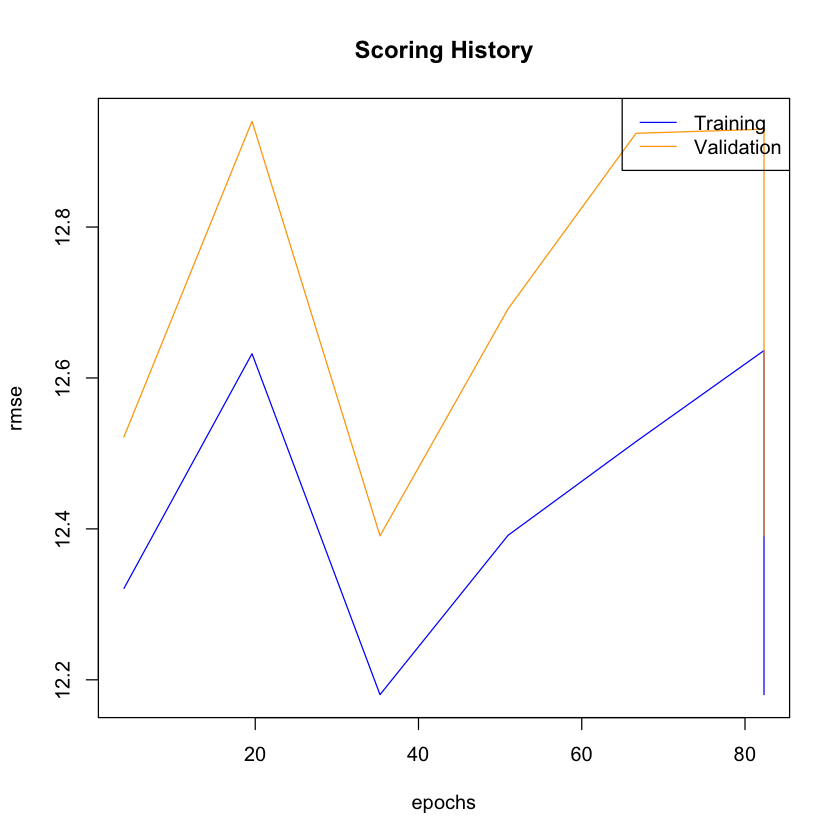

In [48]:
m2 <- h2o.deeplearning(
  model_id="dl_model_faster", 
  training_frame=train, 
  validation_frame=valid,
  x=predictors,
  y=response,
  hidden=c(16,16,16,16),               ## small network, runs faster
  epochs=1000000,                      ## hopefully converges earlier...
  stopping_rounds=2,
  stopping_metric="MSE",               ## could be "MSE","logloss","r2"
  stopping_tolerance=0.01
)
summary(m2)
plot(m2)

Tuning

You can find more information on different tuning parameters in the H2O Deep Learning booklet

https://www.h2o.ai/resources/booklet/deep-learning-with-h2o/
Here we are going to try and use penalty parameters.

In [49]:
m3 <- h2o.deeplearning(
  model_id="dl_model_tuned", 
  training_frame=train, 
  validation_frame=valid, 
  x=predictors, 
  y=response, 
  hidden=c(32,32,32,32),      ## more hidden layers -> more complex interactions
  epochs=1000,                ## to keep it short enough
  score_duty_cycle=0.025,     ## don't score more than 2.5% of the wall time
  l1=1e-5,                    ## add some L1/L2 regularization
  l2=1e-5,
  max_w2=10,                  ## helps stability for Rectifier
  stopping_rounds=2,
  stopping_metric="MSE",      ## could be "MSE","logloss","r2"
  stopping_tolerance=0.01  
) 
summary(m3)

Model Details:

H2ORegressionModel: deeplearning
Model Key:  dl_model_tuned 
Status of Neuron Layers: predicting popularity, regression, gaussian distribution, Quadratic loss, 4,001 weights/biases, 63.4 KB, 3,291,048 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1    24     Input  0.00 %       NA       NA        NA       NA       NA
2     2    32 Rectifier  0.00 % 0.000010 0.000010  0.003192 0.003133 0.000000
3     3    32 Rectifier  0.00 % 0.000010 0.000010  0.003016 0.002340 0.000000
4     4    32 Rectifier  0.00 % 0.000010 0.000010  0.001918 0.002619 0.000000
5     5    32 Rectifier  0.00 % 0.000010 0.000010  0.006245 0.014669 0.000000
6     6     1    Linear      NA 0.000010 0.000010  0.001051 0.000449 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2    0.014434   0.262353  0.434054 0.227945
3   -0.020616   0.252771  0.905908 0.206114
4   -0.050036   0.229439 

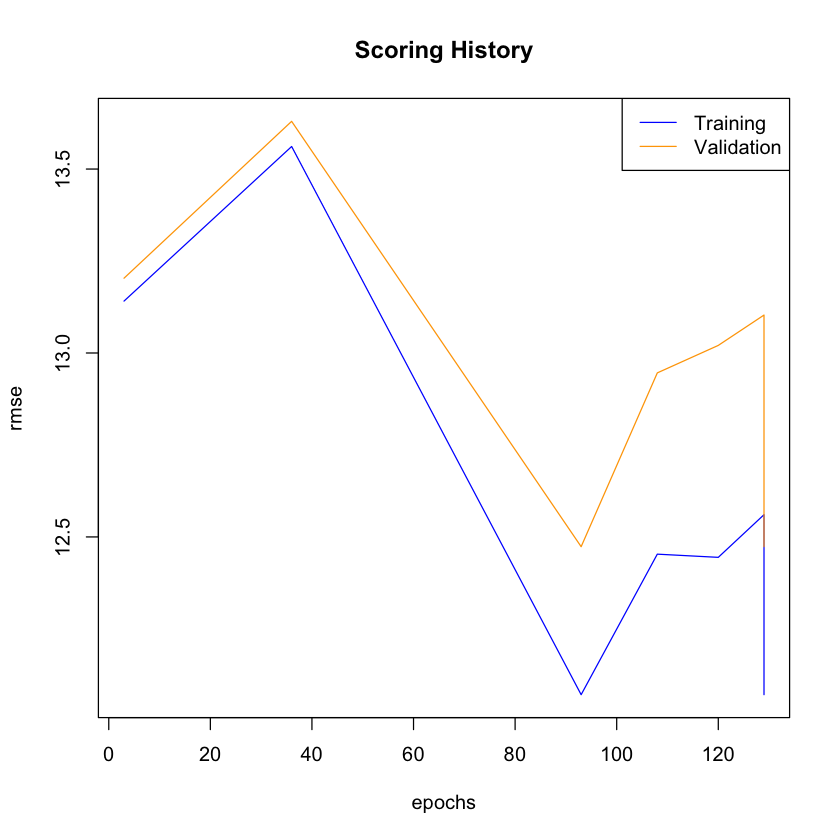

In [50]:
plot(m3)

**Tuning with Grid Search**

A lot of parameters can impact model accuracy

- hyper-parameter tuning is especially important for Deep Learning.


The simplest way is to perform a 
brute-force scan over all combinations 
of specified parameters. 

In [51]:
hyper_params <- list(
  hidden=list(c(32,32,32),c(64,64)),
  input_dropout_ratio=c(0,0.05),
  l1=c(0,1e-5,1e-3),
  l2=c(0,1e-5,1e-3),
  max_w2=c(5,10)
)

grid <- h2o.grid(
  algorithm="deeplearning",
  grid_id="dl_grid", 
  training_frame=train,
  validation_frame=valid, 
  x=predictors, 
  y=response,
  epochs=10,
  stopping_metric="MSE",
  stopping_tolerance=1e-2,        ## stop when MSE does not improve by >=1% for 2 scoring events
  stopping_rounds=2,
  score_duty_cycle=0.025,         ## don't score more than 2.5% of the wall time
  hyper_params=hyper_params
)

In [52]:
grid

H2O Grid Details

Grid ID: dl_grid 
Used hyper parameters: 
  -  hidden 
  -  input_dropout_ratio 
  -  l1 
  -  l2 
  -  max_w2 
Number of models: 144 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing residual_deviance
    hidden input_dropout_ratio     l1     l2 max_w2         model_ids
1 [64, 64]                0.05    0.0  0.001   10.0 dl_grid_model_136
2 [64, 64]                0.05  0.001 1.0E-5    5.0  dl_grid_model_96
3 [64, 64]                0.05 1.0E-5 1.0E-5   10.0 dl_grid_model_128
4 [64, 64]                0.05    0.0 1.0E-5   10.0 dl_grid_model_124
5 [64, 64]                0.05 1.0E-5    0.0   10.0 dl_grid_model_116
   residual_deviance
1 118.11284319587571
2 120.57355017772625
3 128.86344224568361
4 130.69792413860716
5 134.18407313438846

---
          hidden input_dropout_ratio    l1     l2 max_w2        model_ids
139     [64, 64]                0.05 0.001 1.0E-5   10.0 dl_grid_model_60
140     [64, 64]                0.05 0.001  0.0

In [53]:
grid <- h2o.getGrid("dl_grid",sort_by="rmse",decreasing=FALSE)
grid

H2O Grid Details

Grid ID: dl_grid 
Used hyper parameters: 
  -  hidden 
  -  input_dropout_ratio 
  -  l1 
  -  l2 
  -  max_w2 
Number of models: 144 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing rmse
    hidden input_dropout_ratio     l1     l2 max_w2         model_ids
1 [64, 64]                0.05    0.0  0.001   10.0 dl_grid_model_136
2 [64, 64]                0.05  0.001 1.0E-5    5.0  dl_grid_model_96
3 [64, 64]                0.05 1.0E-5 1.0E-5   10.0 dl_grid_model_128
4 [64, 64]                0.05    0.0 1.0E-5   10.0 dl_grid_model_124
5 [64, 64]                0.05 1.0E-5    0.0   10.0 dl_grid_model_116
                rmse
1 10.867973279129632
2 10.980598807793966
3 11.351803479874183
4 11.432319280819932
5 11.583784922657554

---
          hidden input_dropout_ratio    l1     l2 max_w2        model_ids
139     [64, 64]                0.05 0.001 1.0E-5   10.0 dl_grid_model_60
140     [64, 64]                0.05 0.001  0.001   10.0 dl_

In [54]:
# Find the best model and its full set of parameters

grid@summary_table[1,]
best_model <- h2o.getModel(grid@model_ids[[1]])
best_model

,hidden,input_dropout_ratio,l1,l2,max_w2,model_ids,rmse
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,"[64, 64]",0.05,0.0,0.001,10.0,dl_grid_model_136,10.867973279129632


Model Details:

H2ORegressionModel: deeplearning
Model ID:  dl_grid_model_136 
Status of Neuron Layers: predicting popularity, regression, gaussian distribution, Quadratic loss, 5,825 weights/biases, 83.6 KB, 255,120 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1    24     Input  5.00 %       NA       NA        NA       NA       NA
2     2    64 Rectifier  0.00 % 0.000000 0.001000  0.004370 0.003461 0.000000
3     3    64 Rectifier  0.00 % 0.000000 0.001000  0.048816 0.122395 0.000000
4     4     1    Linear      NA 0.000000 0.001000  0.003703 0.008690 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2    0.004263   0.100028  0.085891 0.098968
3   -0.025394   0.099800  0.254792 0.217622
4   -0.024066   0.180873  0.159199 0.000000


H2ORegressionMetrics: deeplearning
** Reported on training data. **
** Metrics reported on temporary training frame with 10068 samples 

In [55]:
h2o.performance(best_model, newdata=test)

H2ORegressionMetrics: deeplearning

MSE:  125.9925
RMSE:  11.22464
MAE:  8.266487
RMSLE:  NaN
Mean Residual Deviance :  125.9925


**Tuning with Random Search**

Hyper-parameter search for more than 4 parameters can be done
more efficiently with random parameter search.

In [56]:
hyper_params <- list(
  activation=c("Rectifier","Tanh","RectifierWithDropout","TanhWithDropout"),
  hidden=list(c(20,20),c(50,50),c(30,30,30),c(25,25,25,25),c(64,64,64,64)),
  input_dropout_ratio=c(0,0.05),
  l1=seq(0,1e-4,1e-6),
  l2=seq(0,1e-4,1e-6),
  max_w2=c(5,10,15)
)

In [57]:
## Stop once the top 5 models are within 1% of each other
## 
##     - the windowed average varies less than 1%
##
search_criteria = list(
  strategy = "RandomDiscrete", 
  max_runtime_secs = 360, 
  max_models = 100, 
  seed=1, 
  stopping_rounds=5,
  stopping_tolerance=1e-2
  )

dl_random_grid <- h2o.grid(
  algorithm="deeplearning",
  grid_id = "dl_grid_random",
  training_frame=train,
  validation_frame=valid, 
  x=predictors, 
  y=response,
  epochs=10,
  stopping_metric="MSE",
  stopping_tolerance=1e-2,        ## stop when MSE does not improve by >=1% for 2 scoring events
  stopping_rounds=2,
  score_duty_cycle=0.025,         ## don't score more than 2.5% of the wall time
  hyper_params = hyper_params,
  search_criteria = search_criteria
)      

In [58]:
grid <- h2o.getGrid("dl_grid_random", sort_by="RMSE", decreasing=FALSE)
grid

H2O Grid Details

Grid ID: dl_grid_random 
Used hyper parameters: 
  -  activation 
  -  hidden 
  -  input_dropout_ratio 
  -  l1 
  -  l2 
  -  max_w2 
Number of models: 89 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing RMSE
  activation           hidden input_dropout_ratio     l1     l2 max_w2
1  Rectifier     [30, 30, 30]                0.05 4.6E-5 6.0E-5   10.0
2  Rectifier         [20, 20]                 0.0 4.7E-5 9.8E-5   15.0
3  Rectifier         [20, 20]                 0.0 7.1E-5 3.9E-5   15.0
4  Rectifier     [30, 30, 30]                0.05 7.5E-5 2.5E-5   10.0
5  Rectifier [25, 25, 25, 25]                0.05 1.0E-4 9.4E-5   15.0
                model_ids               rmse
1 dl_grid_random_model_70 11.677357402661878
2 dl_grid_random_model_66 11.696543439593578
3 dl_grid_random_model_59 11.776246744062616
4 dl_grid_random_model_64 11.815259351980114
5 dl_grid_random_model_63 11.824404538987944

---
        activation           hidden

In [59]:
grid@summary_table[1,]
best_model <- h2o.getModel(grid@model_ids[[1]]) ## model with lowest RMSE
best_model

,activation,hidden,input_dropout_ratio,l1,l2,max_w2,model_ids,rmse
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Rectifier,"[30, 30, 30]",0.05,4.6E-5,6.0E-5,10.0,dl_grid_random_model_70,11.677357402661878


Model Details:

H2ORegressionModel: deeplearning
Model ID:  dl_grid_random_model_70 
Status of Neuron Layers: predicting popularity, regression, gaussian distribution, Quadratic loss, 2,641 weights/biases, 46.5 KB, 255,120 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1    24     Input  5.00 %       NA       NA        NA       NA       NA
2     2    30 Rectifier  0.00 % 0.000046 0.000060  0.003471 0.002753 0.000000
3     3    30 Rectifier  0.00 % 0.000046 0.000060  0.003390 0.001942 0.000000
4     4    30 Rectifier  0.00 % 0.000046 0.000060  0.011673 0.026980 0.000000
5     5     1    Linear      NA 0.000046 0.000060  0.001110 0.000771 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2    0.003181   0.193519  0.393184 0.112416
3   -0.046988   0.174691  0.837579 0.078736
4   -0.037098   0.170709  0.748339 0.136507
5   -0.021789   0.190460  0.032136 0.000000


H2ORegr

In [60]:
h2o.performance(best_model, newdata=test)

H2ORegressionMetrics: deeplearning

MSE:  144.0041
RMSE:  12.00017
MAE:  9.128441
RMSLE:  1.166591
Mean Residual Deviance :  144.0041
